In [ ]:
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.optimize import fmin_powell
from scipy.stats import beta as beta_distribution
import seaborn as sns
from sklearn.linear_model import LogisticRegression

%matplotlib inline
plt.style.use('seaborn')

# Abstract

The goal of this work is to perform simple intercausal reasoning on a 3-node Bayesian network.
<br>
<br>
![](figures/simple_bayesian_network.png)

In this network, both the "president being in town" and a "car accident on the highway" exert influence over whether a traffic jam occurs. With this relationship in mind, we will try to answer two simple questions:
- "What is the probability of an accident having occurred given that a traffic jam occurred?"
- "What is the probability of an accident having occurred given that a traffic jam occurred *and* the president is in town?"

We are given point estimates for all component probabilities which we can use to answer these questions. However, in the real world, we're just given data. As such, we use the given component probabilities (which we'd never actually know) to *simulate* this data, then use it to try to answer the questions at hand. This way, we'll build uncertainty into our answers as well.

# Problem setup

## Define component probabilities

In [ ]:
PRESIDENT_PROBABILITY = .05
ACCIDENT_PROBABILITY = .12
TRAFFIC_PROBABILITY = {(0, 0): .15, (0, 1): .5, (1, 0): .6, (1, 1): .9}
TRIALS = 200

In [3]:
JointInput = namedtuple('JointInput', ['p', 'a'])

## Define PyMC sampling parameters

We'll need these later on.

In [32]:
N_CHAINS = 4
N_SAMPLES = 2000

## Simulate data

In [4]:
president = np.random.binomial(n=1, p=PRESIDENT_PROBABILITY, size=TRIALS)
accident = np.random.binomial(n=1, p=ACCIDENT_PROBABILITY, size=TRIALS)

traffic_probabilities = [TRAFFIC_PROBABILITY[JointInput(p=p, a=a)] for p, a in zip(president, accident)]
traffic = np.random.binomial(n=1, p=traffic_probabilities)

In [5]:
print( f'President Mean: {president.mean()}' )
print( f'Accident Mean: {accident.mean()}' )
print( f'Traffic Mean: {traffic.mean()}')

President Mean: 0.075
Accident Mean: 0.14
Traffic Mean: 0.225


In [6]:
observed_data = pd.DataFrame({'president': president, 'accident': accident, 'traffic': traffic})

# Compute $P(\text{president})$ and $P(\text{accident})$ posteriors

One way to estimate the probability of the president being in town given observational data is to compute the observed proportion, i.e. if the president was seen in 4 of 200 trials, then the estimated probability = .02. Of course, this discards all *uncertainty* in our estimate (of which we have much). Uncertainty declines as the size of our data tends towards infinity, and 200 trials is not infinite.

Instead, we can express our belief - uncertainty included - in the true probability of observing `president`, and that of observing `accident`, as a Beta distributed posterior. This follows trivially from the [Beta-Binomial conjugacy](https://dataorigami.net/products/bayesian-beta-binomial-model)*.

\*Accessing this video costs $9 CAD. This said, the author Cam Davidson Pylon's work on Bayesian statistics is excellent, and well-deserving of the fee. Alternatively, the Wikipedia page on [conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior) contains some cursory information about Beta-Binomial conjugacy under the "Discrete distributions" table.

In [30]:
times_president_observed = sum(president)
times_president_not_observed = len(president) - times_president_observed

president_probability_samples = np.random.beta(
    a=1 + times_president_observed, 
    b=1 + times_president_not_observed, 
    size=N_CHAINS*N_SAMPLES
)

In [31]:
times_accident_observed = sum(accident)
times_accident_not_observed = len(accident) - times_accident_observed

accident_probability_samples = np.random.beta(
    a=1 + times_accident_observed, 
    b=1 + times_accident_not_observed, 
    size=N_CHAINS*N_SAMPLES
)

# Compute $P(\text{Traffic}\ |\ \text{President}, \text{Accident})$ posterior

This might look a little funky for those used to Bayesian parameter estimation for univariate systems - estimating $P(\text{heads})$ given the results of 15 coinflips, for example.

So, how do we do this? Do we filter the data for all unique combinations of (`president`, `accident`), i.e. $(0, 0)$, $(0, 1)$, $(1, 0)$, $(1, 1)$ then estimate in the same fashion as above? That way, we could estimate $P(\text{traffic} = 1\ |\ \text{president} = 0, \text{accident} = 0)$, $P(\text{traffic} = 1\ |\ \text{president} = 1, \text{accident} = 0)$, etc. In fact, this would work. But what if we added more variables? And what if the values are continuous? This would get messy quickly.

In fact, modeling $P(\text{Traffic}\ |\ \text{President}, \text{Accident})$ is none other than logistic regression. Think about it!

Herein, we'll formulate our model as a vanilla Binomial (logistic) regression, taking the form:
<br>
<br>
$$
\text{traffic} \sim \text{Binomial}(1, p)\\
\log\bigg(\frac{p}{1 - p}\bigg) = \alpha + \beta_P P + \beta_A A\\
\alpha \sim \text{Normal}(0, 10)\\
\beta_P \sim \text{Normal}(0, 10)\\
\beta_A \sim \text{Normal}(0, 10)\\
$$

$P$ and $A$ represent `president` and `accident` respectively. The priors on their respective coefficients are meant to be uniformative - a mere guard against our sampler running off to check values really big or really small.

Finally, as this is one of my first times with PyMC3, I fit a baseline logistic regression model from scikit-learn on the same data just to check that our parameter estimates make sense. Note that scikit-learn's implementation specifies an L2 penalty - whose strength is controlled by an additional parameter $C$ - on the cost by default, which is analagous to placing Gaussian priors on model coefficients in the Bayesian case. I did not take care to ensure that the hyper-parameters ($\mu_P$ and $\sigma_P$, for example) of our Normal priors are comparable with the analagous parameter $C$ in the scikit-learn model.

## Baseline logistic regression

In [26]:
glm = LogisticRegression()
_ = glm.fit(X=observed_data[['president', 'accident']], y=observed_data['traffic'])

In [10]:
precision = 5
print( f'Estimated intercept: {glm.intercept_[0]:.{precision}}' )
print( f'Estimated president coefficient: {glm.coef_[0][0]:.{precision}}' )
print( f'Estimated accident coefficient: {glm.coef_[0][1]:.{precision}}' )

Estimated intercept: -1.5952
Estimated president coefficient: 1.3638
Estimated accident coefficient: 1.5207


## Bayesian logistic regression

This way, we get uncertainty in our estimates! Uncertainty is important, as we'll see in following plots.

Sometimes, the chains immediately flatline to a single value. I'm not sure if this is a Bayesian modeling thing, or a PyMC thing. I did not take the time to investigate. Should this happen when running this notebook, kindly try again. If stuck, restart the kernel and start again from there.

In [27]:
with pm.Model() as model:
    priors = {
        'Intercept': pm.Normal.dist(mu=0, sd=10),
        'president': pm.Normal.dist(mu=0, sd=10),
        'accident': pm.Normal.dist(mu=0, sd=10)
    }
    pm.glm.glm('traffic ~ president + accident', observed_data, family=pm.glm.families.Binomial(), priors=priors)
    start_MAP = pm.find_MAP(fmin=fmin_powell, disp=False)
    step = pm.NUTS(scaling=start_MAP)
    trace = pm.sample(N_SAMPLES, step=step, njobs=N_CHAINS, progressbar=True)

100%|██████████| 2000/2000 [00:10<00:00, 190.94it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1240ca630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x123686780>]], dtype=object)

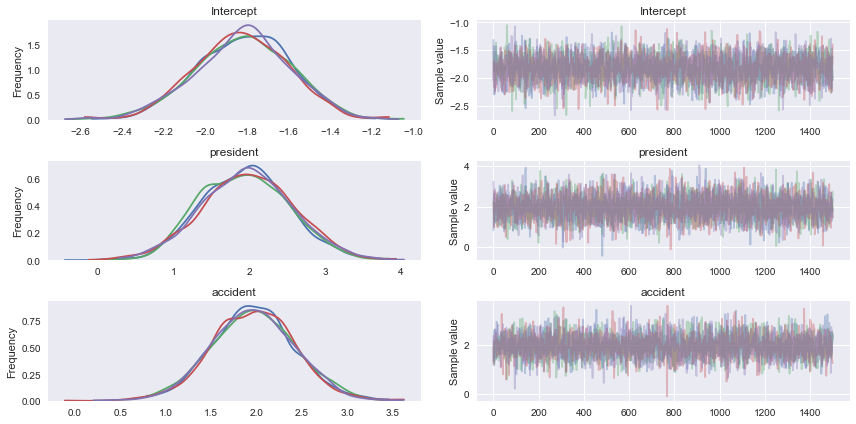

In [28]:
warmup = 500
variables = ['Intercept', 'president', 'accident']

pm.traceplot(trace[warmup:], varnames=variables)

# Compute counterfactual predictions

Our chains look stationary, well-mixing and similar to one another. This signals that our sampler probably did its job. Furthermore, the point estimates computed by the baseline model are contained in our posteriors. As the focus of this work is the overall analysis of the graphical model and not on these specific parameter estimates themselves, I don't dig further.

The next task is to compute counterfactual predictions for $P(\text{Traffic}\ |\ \text{President}, \text{Accident})$, i.e. "given some inputs for $P$ and $A$ in our model, what's the probability of observing `traffic`?" Remember, our model looks as follows:
<br>
<br>
$$
\text{traffic} \sim \text{Binomial}(1, p)\\
\log\bigg(\frac{p}{1 - p}\bigg) = \alpha + \beta_P P + \beta_A A
$$

What values do we use for $\alpha, \beta_P, \beta_A$, you ask? Well, we've got a whole bunch of choices in the cell above.

As such, we'll take the *trace* for each variable - the values returned by the sampler, i.e. the squiggly plot on the right, from which we build the empirical distribution on the left - and plug in some new values for $P$ and $A$. The sampler used 4 chains of 2000 samples each, so we now have 8000 tuples of $(\alpha, \beta_P, \beta_A)$. Our new values for $P$ and $A$ can be whatever we want. (In fact, they don't even have to have been observed in our data to begin with!)

First, we'll take the tuple $(P = 0, A = 0)$. We'll then plug this into our regression equation for each of the 8000 tuples of $(\alpha, \beta_P, \beta_A)$. Solving for $p$, this will give us 8000 values for $P(\text{Traffic} = 1\ |\ \text{President} = 0, \text{Accident} = 0)$. We then repeat for $(P = 0, A = 1), (P = 1, A = 0)$ and $(P = 1, A = 1)$.

In [33]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_counterfactual_predictions(president_value, accident_value, trace=trace):
    log_odds_p = trace['Intercept'] + trace['president']*president_value + trace['accident']*accident_value
    return sigmoid(log_odds_p)

def compute_prediction_interval(predictions, percentile=94):
    lower_percentile_bound = (100 - percentile) / 2
    upper_percentile_bound = 100 - lower_percentile_bound
    return np.percentile(predictions, lower_percentile_bound), np.percentile(predictions, upper_percentile_bound)

In [34]:
input_combinations = [(0, 0), (0, 1), (1, 0), (1, 1)]
counterfactual_predictions = {}
observed_proportions = {}

for p, a in input_combinations:
    counterfactual_predictions[JointInput(p=p, a=a)] = compute_counterfactual_predictions(p, a)
    observed_proportions[JointInput(p=p, a=a)] = \
        observed_data[(observed_data['president'] == p) & (observed_data['accident'] == a)]['traffic'].mean()

# Plot $P(\text{Traffic}\ |\ \text{President}, \text{Accident})$ posteriors

Onto each posterior we also plot:
- The observed traffic proportion, i.e. `observed_data['traffic'].mean()` for the respective set of inputs $(P, A)$.
- The expected proportion, i.e. the original probability of observing traffic given the varying combinations of $(P, A)$. This is what we are trying to recover from our data. In the real world we'd never have this number, but when working with simulated data we can use it as a way to confirm that our model is reasonable.

Finally, we note the uncertainty we're able to express in our estimates. If we instead used the point (i.e. single value) parameter estimates from the scikit-learn model above, we'd be looking at a single value in each plot instead of a distribution.

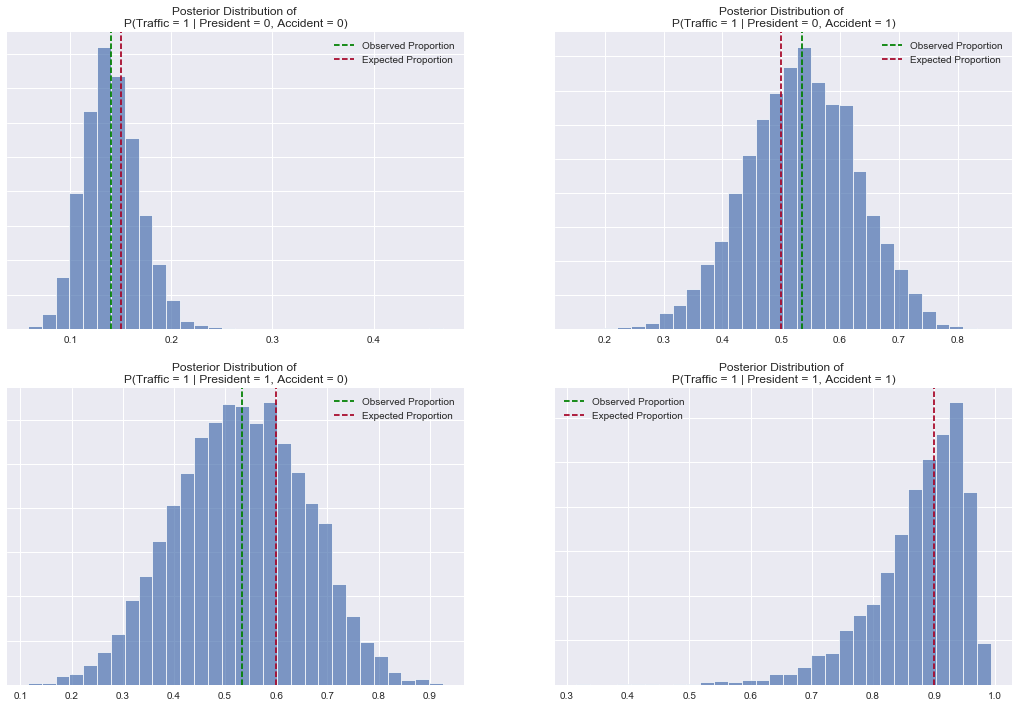

In [35]:
plt.figure(figsize=(18, 12))

for subplot_idx, (p, a) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
    predictions = counterfactual_predictions[JointInput(p=p, a=a)]
    observed_proportion = observed_proportions[JointInput(p=p, a=a)]
    expected_proportion = TRAFFIC_PROBABILITY[JointInput(p=p, a=a)]
    
    subplot = plt.subplot(221 + subplot_idx)
    plt.setp(subplot.get_yticklabels(), visible=False)
    plt.hist(predictions, edgecolor='white', linewidth=1, bins=30, alpha=.7)
    plt.axvline(observed_proportion, color='green', linestyle='--', label='Observed Proportion')
    plt.axvline(expected_proportion, color='#A60628', linestyle='--', label='Expected Proportion')
    title = 'Posterior Distribution of \nP(Traffic = 1 | President = {}, Accident = {})'.format(p, a)
    plt.title(title)
    plt.legend()

# Plot mean and prediction interval for predicted $P(\text{traffic})$

For each unique combination of $(P, A)$ we have 8000 guesses at what $P(\text{Traffic}\ |\ \text{President}, \text{Accident})$ is implied. For each set, we compute a mean and a 94% interval then plot against the observed proportion to see how we did.

Given that our data was generated randomly, it is possible that we don't observe any positive occurrences of `traffic` given varying values of `president` and `accident` - especially at $(T = 1\ |\ P = 1, A = 1)$. As such, there would be no data point in the following plot for the corresponding value of $x$.

We can see that our model given the data is most sure about the probability of observing traffic given neither the president nor an accident. It is least sure about what happens with the former and without the latter. Finally, if the blue and green curves appear identical, do inspect the `y_observed` and `y_predicted_mean` objects to see what the true values are. (In most cases, they will not be identical even if they visually appear to be.)

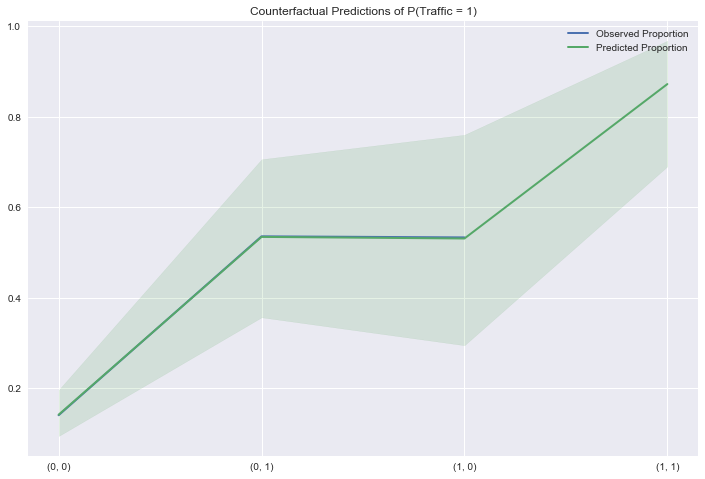

In [42]:
x = [1, 2, 3, 4]
y_observed = list(observed_proportions.values())
labels = [(key.p, key.a) for key in observed_proportions.keys()]

y_predicted_mean = [counterfactual_predictions[joint_input].mean() for joint_input in counterfactual_predictions]
y_predicted_PI = [compute_prediction_interval(counterfactual_predictions[joint_input]) for joint_input in counterfactual_predictions]
y_predicted_PI_lower_bound, y_predicted_PI_upper_bound = zip(*y_predicted_PI)

plt.figure(figsize=(12, 8))
plt.plot(x, y_observed, linewidth=2, label='Observed Proportion')
plt.xticks(x, labels)
plt.plot(x, y_predicted_mean, linewidth=2, label='Predicted Proportion')
plt.fill_between(x, y_predicted_PI_lower_bound, y_predicted_PI_upper_bound, alpha=.1, color='green')
plt.title('Counterfactual Predictions of P(Traffic = 1)')
plt.legend()

# Returning to our original questions

To answer our original questions - $P(\text{Accident = 1}\ |\ \text{Traffic = 1})$ and $P(\text{Accident = 1}\ |\ \text{Traffic = 1}, \text{President = 1})$ - we invoke basic axioms of Bayes' Theorem, conditional probability and the factorization of probabilistic graphical models. Here are the key pieces that we'll need:
<br>
<br>
$$
P(P, A, T) = P(P)P(A)P(T\ |\ P, A)
$$

$$
P(X, Y) = P(X\ |\ Y)P(Y)
$$

$$
P(X\ |\ Y) = \frac{P(Y\ |\ X)P(X)}{P(Y)}
$$

Starting from the beginning, our goal is to reduce each question down to an algebraic expression of the distributions we've estimated from our simulated data. From there, we simply plug and play.

In the distributions that follow, we're able to express the *uncertainty* in our estimates of the true answer to each question. This allows us to:
- **Contextualize our estimate.** Therein, we can make statements like: "There are a ton of plausible values of this probability. If you're going to use it to make a decision or communicate it to others, please do so with caution and don't bet the farm." Conversely, if the following posterior were to be very narrow, we could say things like: "There is a very narrow range of values that satisfy the model given the data. You can be very sure about this probability estimate - perhaps even share it with the CEO!"
- **Make intelligent choices.** If we're going to make bets on traffic, i.e. decide how much money to invest in new urban infrastructure given an estimate of $P(\text{Traffic}\ |\ \text{President})$, different values of $P(\text{Traffic}\ |\ \text{President})$ will suggest different decisions, and each decision will carry a different cost. For example, concurring that the President's appearance causes traffic 80% of the time might lead us to building a new highway - expensive - while concurring 5% might lead us to simply opening the POV lane for the duration of his stay. So, given our estimate, a distribution, of $P(\text{Traffic}\ |\ \text{President})$, how do we know how much money we should budget for the project? This is a motivating example for Bayesian decision theory which, using the entire posterior, allows us to responsibly answer this question. In fact, it's a lot easier than it sounds. My favorite resource on the topic is Rasmus Bååth's ["Probable Points and Credible Intervals, Part 2: Decision Theory"](http://www.sumsar.net/blog/2015/01/probable-points-and-credible-intervals-part-two/).

Finally, we plot the point answer to each question computed from the original probabilities defined at the beginning of this notebook. This gives us an idea of how well were able to recover the initial generative process given only the simulated data.

# $P(\text{Accident = 1}\ |\ \text{Traffic = 1})$
<br>
$\begin{align*}
P(A = 1|T = 1)
  &= \frac{P(T = 1 | A = 1)P(A = 1)}{P(T = 1)}\\
  &= \frac{P(T = 1, A = 1)P(A = 1)}{P(A = 1)P(T = 1)}\\
  &= \frac{P(T = 1, A = 1)}{P(T = 1)}\\
\end{align*}$
<br>
<br>
<br>
$\begin{align*}
P(T = 1, A = 1)
  &= \sum_{P}P(P, A = 1, T = 1))\\
  &= P(P = 0, A = 1, T = 1) + P(P = 1, A = 1, T = 1)\\
  &= P(P = 0)P(A = 1)P(T = 1 \ |\  P = 0, A = 1) + P(P = 1)P(A = 1)P(T = 1 \ |\  P = 1, A = 1)
\end{align*}$
<br>
<br>
<br>
$\begin{align*}
P(T = 1)
  &= \sum_{A, P}P(A, P, T = 1))\\
  &= \sum_{A, P}P(A)P(P)P(T = 1\ |\ A, P))\\
  &=
    P(A = 0)P(P = 0)P(T = 1\ |\ A = 0, P = 0) + P(A = 0)P(P = 1)P(T = 1\ |\ A = 0, P = 1) + P(A = 1)P(P = 0)P(T = 1\ |\ A = 1, P = 0) + P(A = 1)P(P = 1)P(T = 1\ |\ A = 1, P = 1)
\end{align*}$

In [44]:
def compute_P_accident_1_given_traffic_1(president_probability, accident_probability, traffic_probability):
    P_traffic_1_accident_1 = \
        (1 - president_probability)*(accident_probability)*traffic_probability[JointInput(p=0, a=1)] +\
        (president_probability)*(accident_probability)*traffic_probability[JointInput(p=1, a=1)]

    P_traffic_1 = \
        (1 - accident_probability)*(1 - president_probability)*traffic_probability[JointInput(p=0, a=0)] +\
        (1 - accident_probability)*(president_probability)*traffic_probability[JointInput(p=1, a=0)] +\
        (accident_probability)*(1 - president_probability)*traffic_probability[JointInput(p=0, a=1)] +\
        (accident_probability)*(president_probability)*traffic_probability[JointInput(p=1, a=1)]
    
    P_accident_1_given_traffic_1 = P_traffic_1_accident_1 / P_traffic_1
    
    return P_accident_1_given_traffic_1

In [45]:
P_accident_1_given_traffic_1_point_estimate = \
    compute_P_accident_1_given_traffic_1(PRESIDENT_PROBABILITY,ACCIDENT_PROBABILITY,TRAFFIC_PROBABILITY)
    
P_accident_1_given_traffic_1_with_uncertainty = \
    compute_P_accident_1_given_traffic_1(president_probability_samples, accident_probability_samples, counterfactual_predictions)

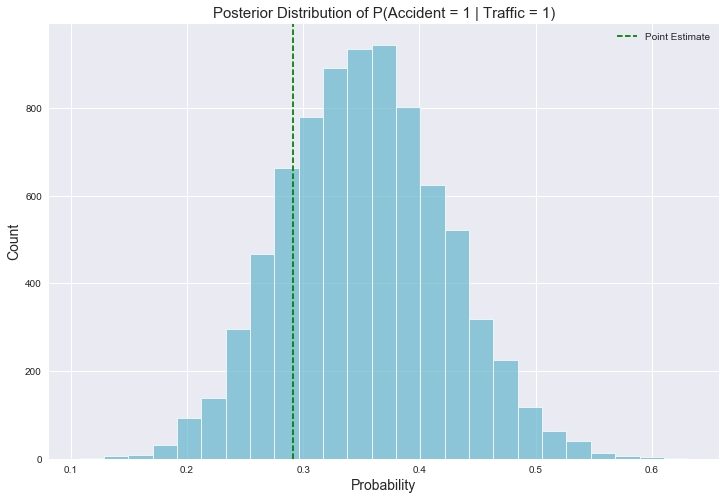

In [46]:
color = sns.color_palette()[-1]

plt.figure(figsize=(12, 8))
plt.hist(P_accident_1_given_traffic_1_with_uncertainty, linewidth=1, bins=25, color=color, edgecolor='white', alpha=.7)
plt.title('Posterior Distribution of P(Accident = 1 | Traffic = 1)', fontsize=15)
plt.axvline(P_accident_1_given_traffic_1_point_estimate, color='green', linestyle='--', label='Point Estimate')
plt.xlabel('Probability', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend()

# $P(\text{Accident = 1}\ |\ \text{Traffic = 1}, \text{President = 1})$
<br>
$\begin{align*}
P(A = 1\ |\ T = 1, P = 1)
  &= \frac{P(A = 1, T = 1, P = 1)}{P(T = 1, P = 1)}
\end{align*}$
<br>
<br>
<br>
$\begin{align*}
P(A = 1, T = 1, P = 1)
  &= P(T = 1\ |\ A = 1, P = 1)P(A = 1)P(P = 1)
\end{align*}$
<br>
<br>
<br>
$\begin{align*}
P(T = 1, P = 1)
  &= \sum_{A}P(A, P = 1, T = 1)\\
  &= P(A = 0, P = 1, T = 1) + P(A = 1, P = 1, T = 1)\\
  &= P(T = 1\ |\ A = 0, P = 1)P(P = 1)P(A = 0) + P(T = 1\ |\ A = 1, P = 1)P(P = 1)P(A = 1)
\end{align*}$

In [47]:
def compute_P_accident_1_given_traffic_1_president_1(president_probability, accident_probability, traffic_probability):
    P_accident_1_traffic_1_president_1 = \
        traffic_probability[JointInput(p=1, a=1)]*accident_probability*president_probability
        
    P_traffic_1_president_1 = \
        traffic_probability[JointInput(p=1, a=0)]*president_probability*(1 - accident_probability) +\
        traffic_probability[JointInput(p=1, a=1)]*president_probability*accident_probability
        
    P_accident_1_given_traffic_1_president_1 = P_accident_1_traffic_1_president_1 / P_traffic_1_president_1
    
    return P_accident_1_given_traffic_1_president_1

In [48]:
P_accident_1_given_traffic_1_president_1_point_estimate = \
    compute_P_accident_1_given_traffic_1_president_1(PRESIDENT_PROBABILITY,ACCIDENT_PROBABILITY,TRAFFIC_PROBABILITY)
    
P_accident_1_given_traffic_1_president_1_with_uncertainty = \
    compute_P_accident_1_given_traffic_1_president_1(president_probability_samples, accident_probability_samples, counterfactual_predictions)

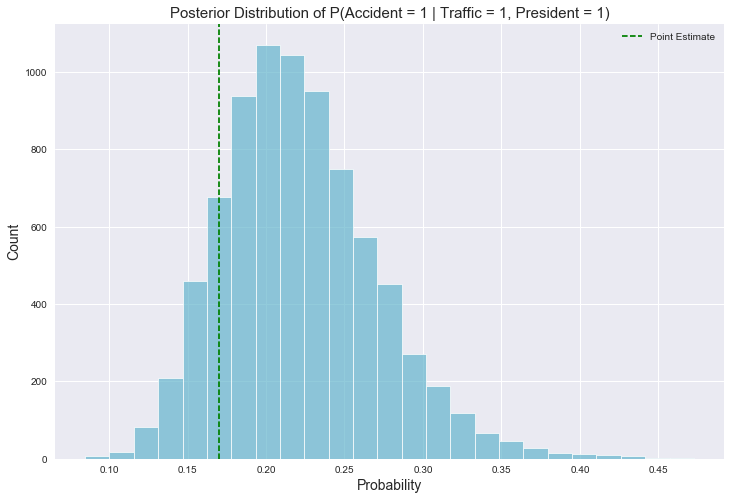

In [49]:
plt.figure(figsize=(12, 8))
plt.hist(P_accident_1_given_traffic_1_president_1_with_uncertainty, 
         bins=25, color=color, linewidth=1, edgecolor='white', alpha=.7)
plt.title('Posterior Distribution of P(Accident = 1 | Traffic = 1, President = 1)', fontsize=15)
plt.axvline(P_accident_1_given_traffic_1_president_1_point_estimate, color='green', linestyle='--', label='Point Estimate')
plt.xlabel('Probability', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend()

# But didn't this all depend on how the dice were rolled?


To conclude, I'd like to give some basic context on the stochasticity of the generative process itself. We said above that the probability of observing an accident is `ACCIDENT_PROBABILITY = .12`. We then simulated 200 trials and observed a discrete count. While the expectation of this count is $200 * .12 = 24$ accidents observed, we could have also observed 23, or 31, or even (but implausibly) 0. Next, we used this data to infer a posterior distribution for the true value of `ACCIDENT_PROBABILITY`, and later plugged it in to the expressions corresponding to the original questions at hand. How much did the stochasticity of these trials impact the result?

The following data cover 200 more trials. In each, we "flip the coin" 99 times, instead of 1 time as was done above. In each trial, we plot the inferred posterior distribution for the true probability of `accident`. The distribution of the median observed count is overlaid in bold.

As is clear, the expected values of these posteriors can vary wildly! In fact, the left tails of some *barely touch* the right tails of others. By all accounts, this will absolutely affect our final estimates. Is there anything we can do about it?

As yet, I see two options:
- **Give an informative prior.** The canonical Beta-Binomial formulation we've used implies a flat prior - $\text{Beta}(1, 1)$. A more informative prior would come from domain-level knowledge about how often traffic accidents occur.
- **Build a better model.** Perhaps there are other variables that directly contribute to accidents - weather, time of day, etc.? If such data were obtainable we should use them to try to explain the variance in our outcome `accident`. In fact, this is a much more general point for a future analysis: these are outside of the scope of our original graph itself.

Finally, here's a fitting quote that makes me smile:
> “And with real data, these models will never accurately recover the data-generating mechanism. At best, they describe it in a scientifically useful way.” - Richard McElreath

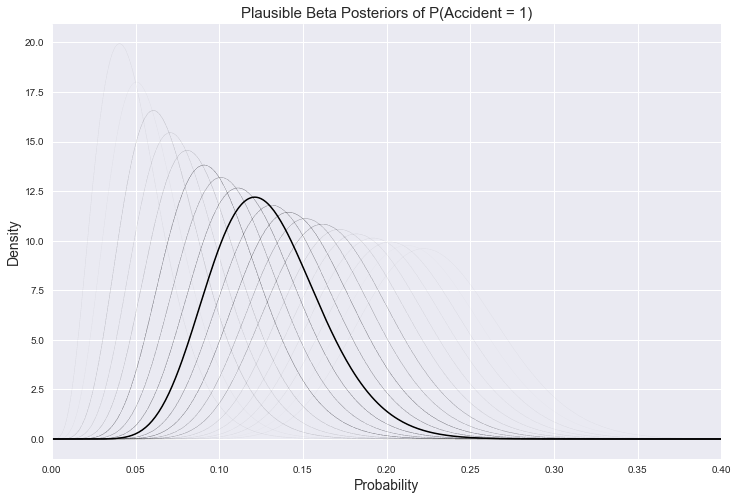

In [25]:
N = 99
x = np.linspace(0, 1, 1002)[1:-1]
accident_trials = np.random.binomial(n=N, p=ACCIDENT_PROBABILITY, size=TRIALS)
plt.figure(figsize=(12, 8))
plt.xlim(0, .4)

def compute_beta_densities(yes_count, x=x):
    no_count = N - yes_count
    alpha = 1 + yes_count
    beta = 1 + no_count
    distribution = beta_distribution(alpha, beta)
    return distribution.pdf(x)

for yes_count in accident_trials:
    y = compute_beta_densities(yes_count)
    plt.plot(x, y, color='black', linewidth=.5, alpha=.02)
    
median_yes_count = np.median(accident_trials)
y = compute_beta_densities(median_yes_count)
plt.plot(x, y, color='black', linewidth=1.5, alpha=1)
plt.title('Plausible Beta Posteriors of P(Accident = 1)', fontsize=15)
plt.xlabel('Probability', fontsize=14)
plt.ylabel('Density', fontsize=14)